# Enhancing Yolov3 performance by using data augmentation

## Step 1: Preparing dataset for 2 different models

##### Reading all images and annotations-> converting bbox to Yolov3 format -> apply data augmentation -> save into 2 folders -> read from folders to test

###### Zid: Z5330875 Full name: Tsenguun Odgerel

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.util import random_noise
from PIL import Image
import json
from collections import defaultdict
import glob
import os
import zipfile


json_path = './archive/train_annotations'
train_path = "./archive/train/train"

#Preparing training train_model1 -  500 images, train_model2 - 6000 images
model1_path = './archive/train_model1'
model2_path = './archive/train_model2'


all_images = defaultdict(list)
aug_image = defaultdict(list)


In [2]:
class ImageProcess:
    def __init__(self, train_path, model1_path, model2_path):
        self.path = train_path
        self.images = []
        self.category_and_bboxes = []
        self.width = 640
        self.height = 640
        self.model1_path = model1_path
        self.model2_path = model2_path
        self.creating_path(model1_path)
        self.creating_path(model2_path)
        
    #Creating path
    def creating_path(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
            print("Path created")
        else:
            print("Path existed")
            
    #Reading images
    def read_images(self):
        files_in_directory = os.listdir(self.path)
        jpg_files = [file for file in files_in_directory if file.endswith(".jpg")]
        jpg_files = sorted(jpg_files)
        for image_name in jpg_files:
            image_path = os.path.join(self.path, image_name)
            image = cv2.imread(image_path)
            self.images.append(image)
        return self.images
    
    #Reading annotations
    def read_json(self, path):
        with open(path, 'r') as json_file:
            data = json.load(json_file)
        self.category_and_bboxes = [(item['category_id'], item['bbox']) for item in data]
        return self.category_and_bboxes
    
    #Reading bbox from annotation
    def read_image_bboxes(self, id):
        bboxes = self.category_and_bboxes[id][1] 
        x_min = bboxes[0]
        y_min = bboxes[1]
        width = bboxes[2]
        height = bboxes[3]
        x_max = x_min+width
        y_max = y_min+height
        bboxes_corner = np.array([
                        [x_min, y_min],
                        [x_max, y_min],
                        [x_max, y_max],
                        [x_min, y_max]
                     ])
        category = self.category_and_bboxes[id][0]
        
        return self.images[id], category,  bboxes_corner

    ##convert bounding box format - x1, y1, x2, y2 to x,y,w,
    def corner_to_yolo(self, bbox, isrotated):
        if isrotated:
            bbox = np.array(bbox, dtype=np.float32)

            # Compute the axis-aligned bounding box
            # cv2.minAreaRect returns a Box2D structure - ( center (x,y), (width, height), angle of rotation ).
            rect = cv2.minAreaRect(bbox)

            # cv2.boxPoints(rect) for getting vertices of a rotated rectangle where rect is Box2D
            bbox = cv2.boxPoints(rect)

            # Get min and max coordinates of bounding box vertices
            x_min, y_min = np.min(bbox, axis=0)
            x_max, y_max = np.max(bbox, axis=0)

            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            
        else:
            x_center = (bbox[0][0] + bbox[2][0]) / 2
            y_center = (bbox[0][1] + bbox[2][1]) / 2
            bbox_width = bbox[2][0] - bbox[0][0]
            bbox_height = bbox[2][1] - bbox[0][1]

        x_center /= self.width
        y_center /= self.height
        bbox_width /= self.width
        bbox_height /= self.height
        yolo_bbox = [x_center, y_center, bbox_width, bbox_height]
        return yolo_bbox   
    
    
     ##convert bounding box format - x, y, w, h to x1, y1, x2, y2
    def yolo_to_corner(self, yolo_bbox):
        x_center = yolo_bbox[0] * self.width
        y_center = yolo_bbox[1] * self.height
        bbox_width = yolo_bbox[2] * self.width
        bbox_height = yolo_bbox[3] * self.height

        x_min = x_center - (bbox_width / 2)
        y_min = y_center - (bbox_height / 2)
        x_max = x_center + (bbox_width / 2)
        y_max = y_center + (bbox_height / 2)

        original_bbox = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]
        return original_bbox

    #display bbox on image
    def display_img_bbox(self, image, bboxes_corner):
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        rect = patches.Polygon(bboxes_corner, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.axis('on')
        plt.show()
        
    ############################################
    #######IMAGE PROCESSING STEPS ##############
    #######1. Salt and Pepper noise#############
    #######2. Random Crop#######################
    #######3. Flip XY ##########################
    #######4. Brigthen & Darken ################
    #######5. Rotate with minus & plus degree ##
    #######6. Contrast #########################
    #######7. Zoom in & out ####################
    ############################################
    def aug_noise(self, image, bboxes_corner, isdisplay):
        prob_salt = 0.02
        prob_pepper = 0.02

        salt_mask = np.random.rand(*image.shape[:2]) < prob_salt
        pepper_mask = np.random.rand(*image.shape[:2]) < prob_pepper

        noisy_image_salt_pepper = np.copy(image)
        noisy_image_salt_pepper[salt_mask] = 255
        noisy_image_salt_pepper[pepper_mask] = 0

        if isdisplay:
            self.display_img_bbox(noisy_image_salt_pepper, bboxes_corner) 
        return noisy_image_salt_pepper, bboxes_corner
    def aug_random_crop_resize(self, image, bboxes_edge, crop_size, isdisplay, output_size=(640, 640)):
        x_min = min([point[0] for point in bboxes_edge])
        y_min = min([point[1] for point in bboxes_edge])
        x_max = max([point[0] for point in bboxes_edge])
        y_max = max([point[1] for point in bboxes_edge])

        y_crop = np.random.randint(0, image.shape[0] - crop_size[0])
        x_crop = np.random.randint(0, image.shape[1] - crop_size[1])

        cropped_image = image[y_crop:y_crop + crop_size[0], x_crop:x_crop + crop_size[1]]
        cropped_bboxes = [[max(0, point[0] - x_crop), max(0, point[1] - y_crop)] for point in bboxes_edge]

        resized_cropped_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_LINEAR)
        resize_scale_x = output_size[0] / crop_size[1]
        resize_scale_y = output_size[1] / crop_size[0]

        resized_bboxes = [[min(point[0] * resize_scale_x, output_size[0]), min(point[1] * resize_scale_y, output_size[1])] for point in cropped_bboxes]
        
        if isdisplay:
            self.display_img_bbox(resized_cropped_image, resized_bboxes)

        return resized_cropped_image, resized_bboxes
    def aug_flip(self, image, bboxes_corner, axis, isdisplay):
        flipped_image = cv2.flip(image, axis)  # 1 means flipping around y-axis, use 0 for x-axis
        
        if axis == 1:  # Flip corners around y-axis
            flipped_bbox = [[self.width - point[0], point[1]] for point in bboxes_corner]
        else:  # Flip corners around x-axis
            flipped_bbox = [[point[0], self.height - point[1]] for point in bboxes_corner]
        
        if isdisplay:
            self.display_img_bbox(flipped_image, flipped_bbox)
        return flipped_image, flipped_bbox


    def aug_brightness(self, image, bbox_corner, brightness_factor, isdisplay):
        #brightness_factor positive - brighten
        #brightness_factor negative - darken

        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        hsv = np.array(hsv, dtype = np.float64)
        hsv[:,:,1] = hsv[:,:,1]*brightness_factor
        hsv[:,:,1][hsv[:,:,1]>255]  = 255
        hsv[:,:,2] = hsv[:,:,2]*brightness_factor

        hsv = np.array(hsv, dtype = np.uint8)
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        
        if isdisplay:
            self.display_img_bbox(img, bbox_corner)
        return img, bbox_corner

    def aug_rotate(self, image, bboxes_corner, angle, isdisplay):
        center = (self.height//2,self.width//2)
        rotMat = cv2.getRotationMatrix2D(center,angle,1.0)

        image_rotated = cv2.warpAffine(image,rotMat,image.shape[1::-1]) #Rotate the image

        bboxes_rotated = np.vstack((bboxes_corner.T,np.array((1,1,1,1)))) #Convert the array to [x,y,1] format to dot it with the rotMat
        bboxes_rotated = np.dot(rotMat,bboxes_rotated).T 
        
        if isdisplay:
            self.display_img_bbox(image_rotated, bboxes_rotated)
        return image_rotated, bboxes_rotated 

    def aug_contrast(self, image, bboxes_corner, contrast_factor, isdisplay):
        img = image.astype(float)
        img = img * contrast_factor 
        img = np.clip(img, 0, 255)
        img = img.astype(np.uint8)
        
        if isdisplay:
            self.display_img_bbox(img, bboxes_corner)
        return img, bboxes_corner

    def aug_zoom(self, image, bboxes_corner, zoom_factor, isdisplay):
#         height, width = image.shape[:2]
        new_height, new_width = int(self.height * zoom_factor), int(self.width * zoom_factor)
        zoomed = cv2.resize(image, (new_width, new_height))

        if zoom_factor > 1:
            top = (new_height - self.height) // 2
            left = (new_width - self.width) // 2
            zoomed = zoomed[top: top + self.height, left: left + self.width]
        else:
            pad_top = (self.height - new_height) // 2
            pad_left = (self.width - new_width) // 2
            zoomed = cv2.copyMakeBorder(zoomed, pad_top, pad_top, pad_left, pad_left, cv2.BORDER_CONSTANT, value=0)

        adjusted_bboxes_corner = []

        for point in bboxes_corner:
            x, y = point
            x_zoomed = x * zoom_factor
            y_zoomed = y * zoom_factor

            if zoom_factor > 1:
                crop_offset_x = ((zoom_factor - 1) / 2) * self.width
                crop_offset_y = ((zoom_factor - 1) / 2) * self.height
                x_zoomed -= crop_offset_x
                y_zoomed -= crop_offset_y
            else:
                pad_offset_x = ((1 - zoom_factor) / 2) * self.width
                pad_offset_y = ((1 - zoom_factor) / 2) * self.height
                x_zoomed += pad_offset_x
                y_zoomed += pad_offset_y

            x_zoomed = max(0, x_zoomed)
            y_zoomed = max(0, y_zoomed)
            x_zoomed = min(self.width, x_zoomed)
            y_zoomed = min(self.height, y_zoomed)

            adjusted_bboxes_corner.append([int(x_zoomed), int(y_zoomed)])
        
        if isdisplay:
            self.display_img_bbox(zoomed, np.array(adjusted_bboxes_corner))
        return zoomed, np.array(adjusted_bboxes_corner)

    def display_images_all(self, aug_images):
        fig, axs = plt.subplots(3, 4, figsize=(9, 8))
        fig.tight_layout()
        for index, (key, (aug_image, aug_bboxes)) in enumerate(aug_images.items()):
            row = index // 4
            col = index % 4
            rect = patches.Polygon(aug_bboxes, linewidth=1, edgecolor='r', facecolor='none')
            axs[row, col].add_patch(rect)
            axs[row, col].imshow(aug_image)
            axs[row, col].set_title(key)
            axs[row, col].axis('on')
        plt.show()
        
    def image_txt_saving(self, all_aug_images, all_categories, path, isaugmented):
        for i in range(len(all_aug_images)):
            IMAGE_ID = ('00' + str(i))[-3:]
            category = all_categories[i]
         
            if isaugmented:
                for index, (key, (aug_image, aug_bboxes)) in enumerate(all_aug_images[i].items()):
                    image_name = 'image_id_'+str(IMAGE_ID)+'_'+str(index)
                    cv2.imwrite(f'{path}/{image_name}.jpg', aug_image)
                    if key in ['RotateMinus', 'RotatePlus']:
                        bboxes_yolo = self.corner_to_yolo(aug_bboxes, True)
                    else:
                        bboxes_yolo = self.corner_to_yolo(aug_bboxes, False)

                    with open(f'{path}/{image_name}.txt', 'w') as file:
                        file.write(f'{category-1} {bboxes_yolo[0]} {bboxes_yolo[1]} {bboxes_yolo[2]} {bboxes_yolo[3]}\n')

            else:
                aug_image, aug_bboxes = all_aug_images[i]  # unpack the tuple
                image_name = 'image_id_'+str(IMAGE_ID)
                cv2.imwrite(f'{path}/{image_name}.jpg', aug_image)
                bboxes_yolo = self.corner_to_yolo(aug_bboxes, False)
                with open(f'{path}/{image_name}.txt', 'w') as file:
                    file.write(f'{category-1} {bboxes_yolo[0]} {bboxes_yolo[1]} {bboxes_yolo[2]} {bboxes_yolo[3]}\n')
                    
    ##Validate images and bbox after saving into folder
    def read_images_and_bboxes(self, index, path):
        files_in_directory = os.listdir(path)
        images = []
        bboxes = []
        aug_images = dict()
        files_in_directory = sorted(files_in_directory)
        for file in files_in_directory:
            if(int(file.split('_')[2][:3])) == index:
                if file.endswith('.jpg'):
                    image_path = os.path.join(path, file)
                    image = cv2.imread(image_path)
                    images.append(image)
                    bbox_path = image_path[:-3] + 'txt'
                    with open(bbox_path, 'r') as f:
                        bbox = f.read().strip().split()  # assuming each file contains one bbox
                        bbox = [float(x) for x in bbox]  # convert string to float
                    bboxes_corner = self.yolo_to_corner(bbox[1:])
                    bboxes.append(bboxes_corner)
        
        for i, image in enumerate(images):
            aug_images[i] = image, bboxes[i]
        self.display_images_all(aug_images)

## 01 declaring object and reading images

In [3]:
image_process = ImageProcess(train_path, 
                             model1_path,
                             model2_path)

#Reading all images
all_images = image_process.read_images()
#Reading category and bbox
category_and_bboxes = image_process.read_json(json_path)

Path created
Path created


## 02 Reading all images, bounding box and applying 11 augmentation approaches
#### saving into all_aug_images list

In [4]:
all_aug_images = []
all_categories = []
isdisplay = False ##Not displaying images just for testing case
for i in range(len(all_images)):
    aug_image = defaultdict(list)
    image, category, bboxes_corner = image_process.read_image_bboxes(i)
    
    aug_image['original'] = image, bboxes_corner
    aug_image['noise'] = image_process.aug_noise(image, bboxes_corner, isdisplay)
    
    crop_size = (416, 416)
    aug_image['cropped'] = image_process.aug_random_crop_resize(image, bboxes_corner, crop_size, isdisplay)
    
    ###3. Flip image Y coordinate
    aug_image['FlipY'] = image_process.aug_flip(image, bboxes_corner, 0, isdisplay)

    ###4. Flip image X cooridnate
    aug_image['FlipX'] = image_process.aug_flip(image, bboxes_corner, 1, isdisplay)

    ###5. Rotate minus
    angle = 30
    aug_image['RotateMinus']  = image_process.aug_rotate(image, bboxes_corner, -angle, isdisplay)
    ###6. Rotate plus
    aug_image['RotatePlus']  = image_process.aug_rotate(image, bboxes_corner, angle, isdisplay)

    ###7. Brigthen 
    brigthen = 2
    aug_image['bright'] =  image_process.aug_brightness(image, bboxes_corner, brigthen, isdisplay) #Bright

    ###8. Darken image
    aug_image['dark'] = image_process.aug_brightness(image, bboxes_corner, -brigthen, isdisplay) #dark

    ###9. Contrast 
    contrast_factor = 3.5
    aug_image['contrast']  = image_process.aug_contrast(image, bboxes_corner, contrast_factor, isdisplay)

    ###10. Zoomout
    zoomout_factor = 0.5
    aug_image['zoomout'] = image_process.aug_zoom(image, bboxes_corner, zoomout_factor, isdisplay)
    ###11. Zoomin
    zoomin_factor = 1.5
    aug_image['zoomin'] = image_process.aug_zoom(image, bboxes_corner, zoomin_factor, isdisplay)
    
    
    all_aug_images.append(aug_image)
    all_categories.append(category) ## adjusting from 1-2 to 0-1
    
    
##Storing 500 images
original_images = [image['original'] for image in all_aug_images]

## 03 Saving into model1, model2 training data to the folders

In [5]:
#saving 500 images to model1_path
isaugmented = False
image_process.image_txt_saving(original_images[:2], all_categories, 
                               model1_path, isaugmented)

#saving image processed 500+5500 images with processed to model2_path
isaugmented = True
image_process.image_txt_saving(all_aug_images[:2], all_categories, 
                               model2_path, isaugmented)

## 04 Displaying images from array of a given index for test purpose

In [6]:
#display augmentad images by index
image_process.display_images_all(all_aug_images[1])

## 05 Displaying images from folder of a given index for test purpose

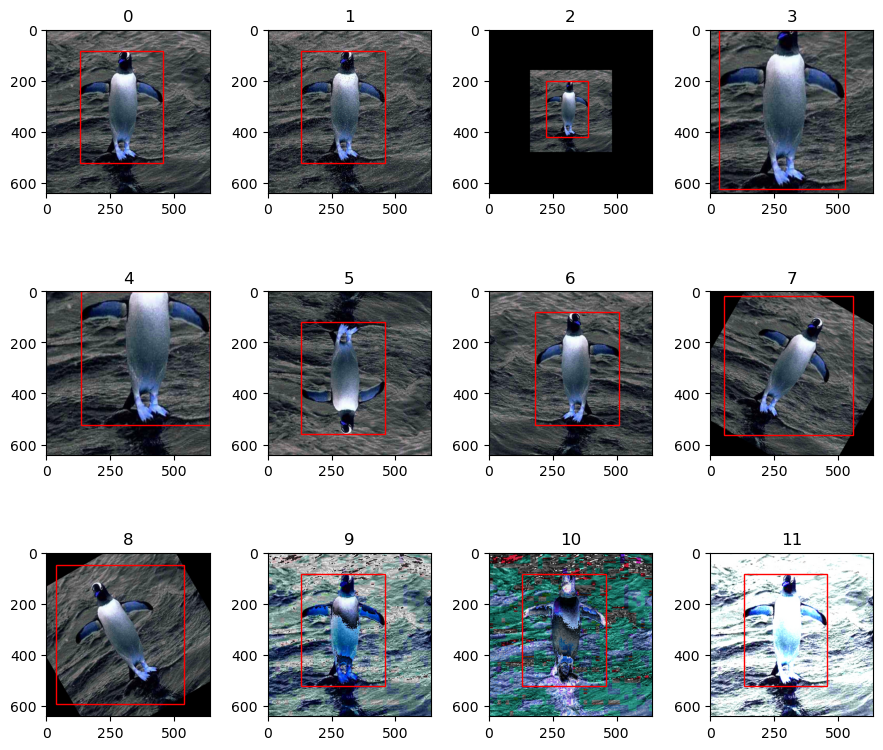

In [7]:
# #display augmentad images in a folder after converted to YOLO BBOX by index
# image_process.read_images_and_bboxes(1, model1_path)

#display augmentad images in a folder after converted to YOLO BBOX by index
image_process.read_images_and_bboxes(1, model2_path)

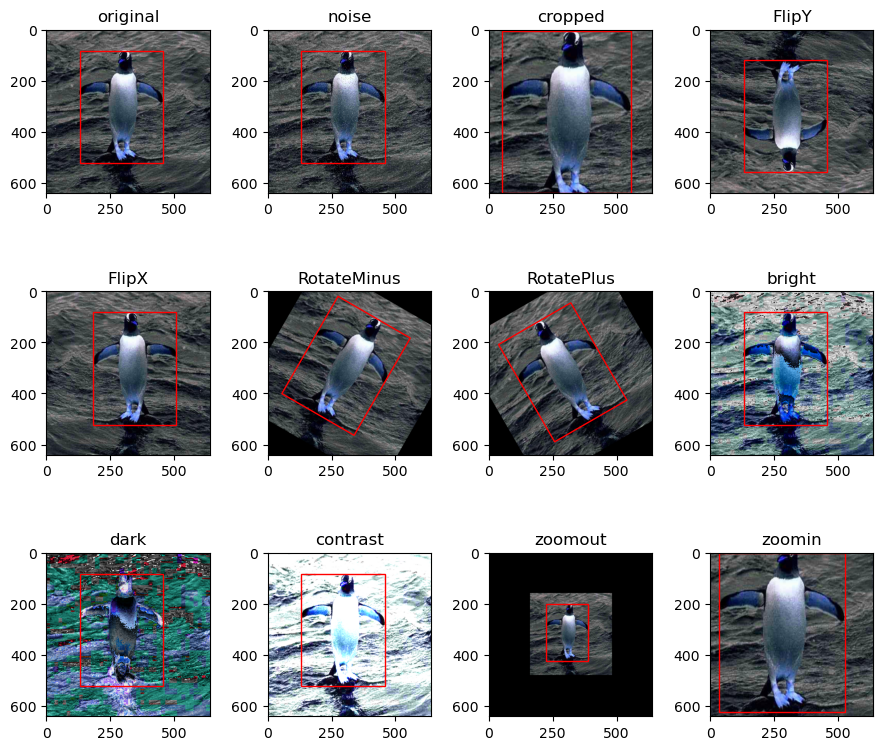

In [31]:
#display augmentad images by index
image_process.display_images_all(all_aug_images[1])